In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import shap

# Важная настройка для корректной настройки pipeline!
import sklearn
sklearn.set_config(transform_output="pandas")

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder, TargetEncoder
from sklearn.model_selection import GridSearchCV, KFold
from category_encoders import TargetEncoder

# for model learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

#models
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.linear_model import LinearRegression,  Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import  VotingClassifier, RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.inspection import permutation_importance
from sklearn.feature_selection import f_regression, chi2
from scipy.stats import ttest_ind
from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings('ignore')


# Metrics
from sklearn.metrics import root_mean_squared_log_error, mean_squared_error, root_mean_squared_error


# tunning hyperparamters model
import optuna
import math
import joblib

In [429]:
%matplotlib inline

In [2]:
train_url = 'https://raw.githubusercontent.com/AlexChen-13/houses_prices/main/train.csv'
train = pd.read_csv(train_url)
test_url = 'https://raw.githubusercontent.com/AlexChen-13/houses_prices/main/test.csv'
test = pd.read_csv(test_url)

In [3]:
test


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


(array([148., 723., 373., 135.,  51.,  19.,   4.,   3.,   2.,   2.]),
 array([ 34900., 106910., 178920., 250930., 322940., 394950., 466960.,
        538970., 610980., 682990., 755000.]),
 <BarContainer object of 10 artists>)

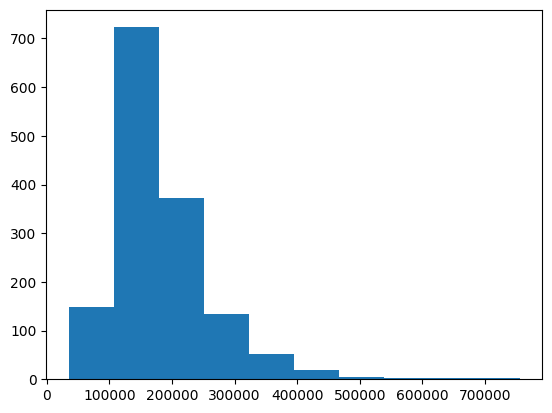

In [4]:
plt.hist(train['SalePrice'])

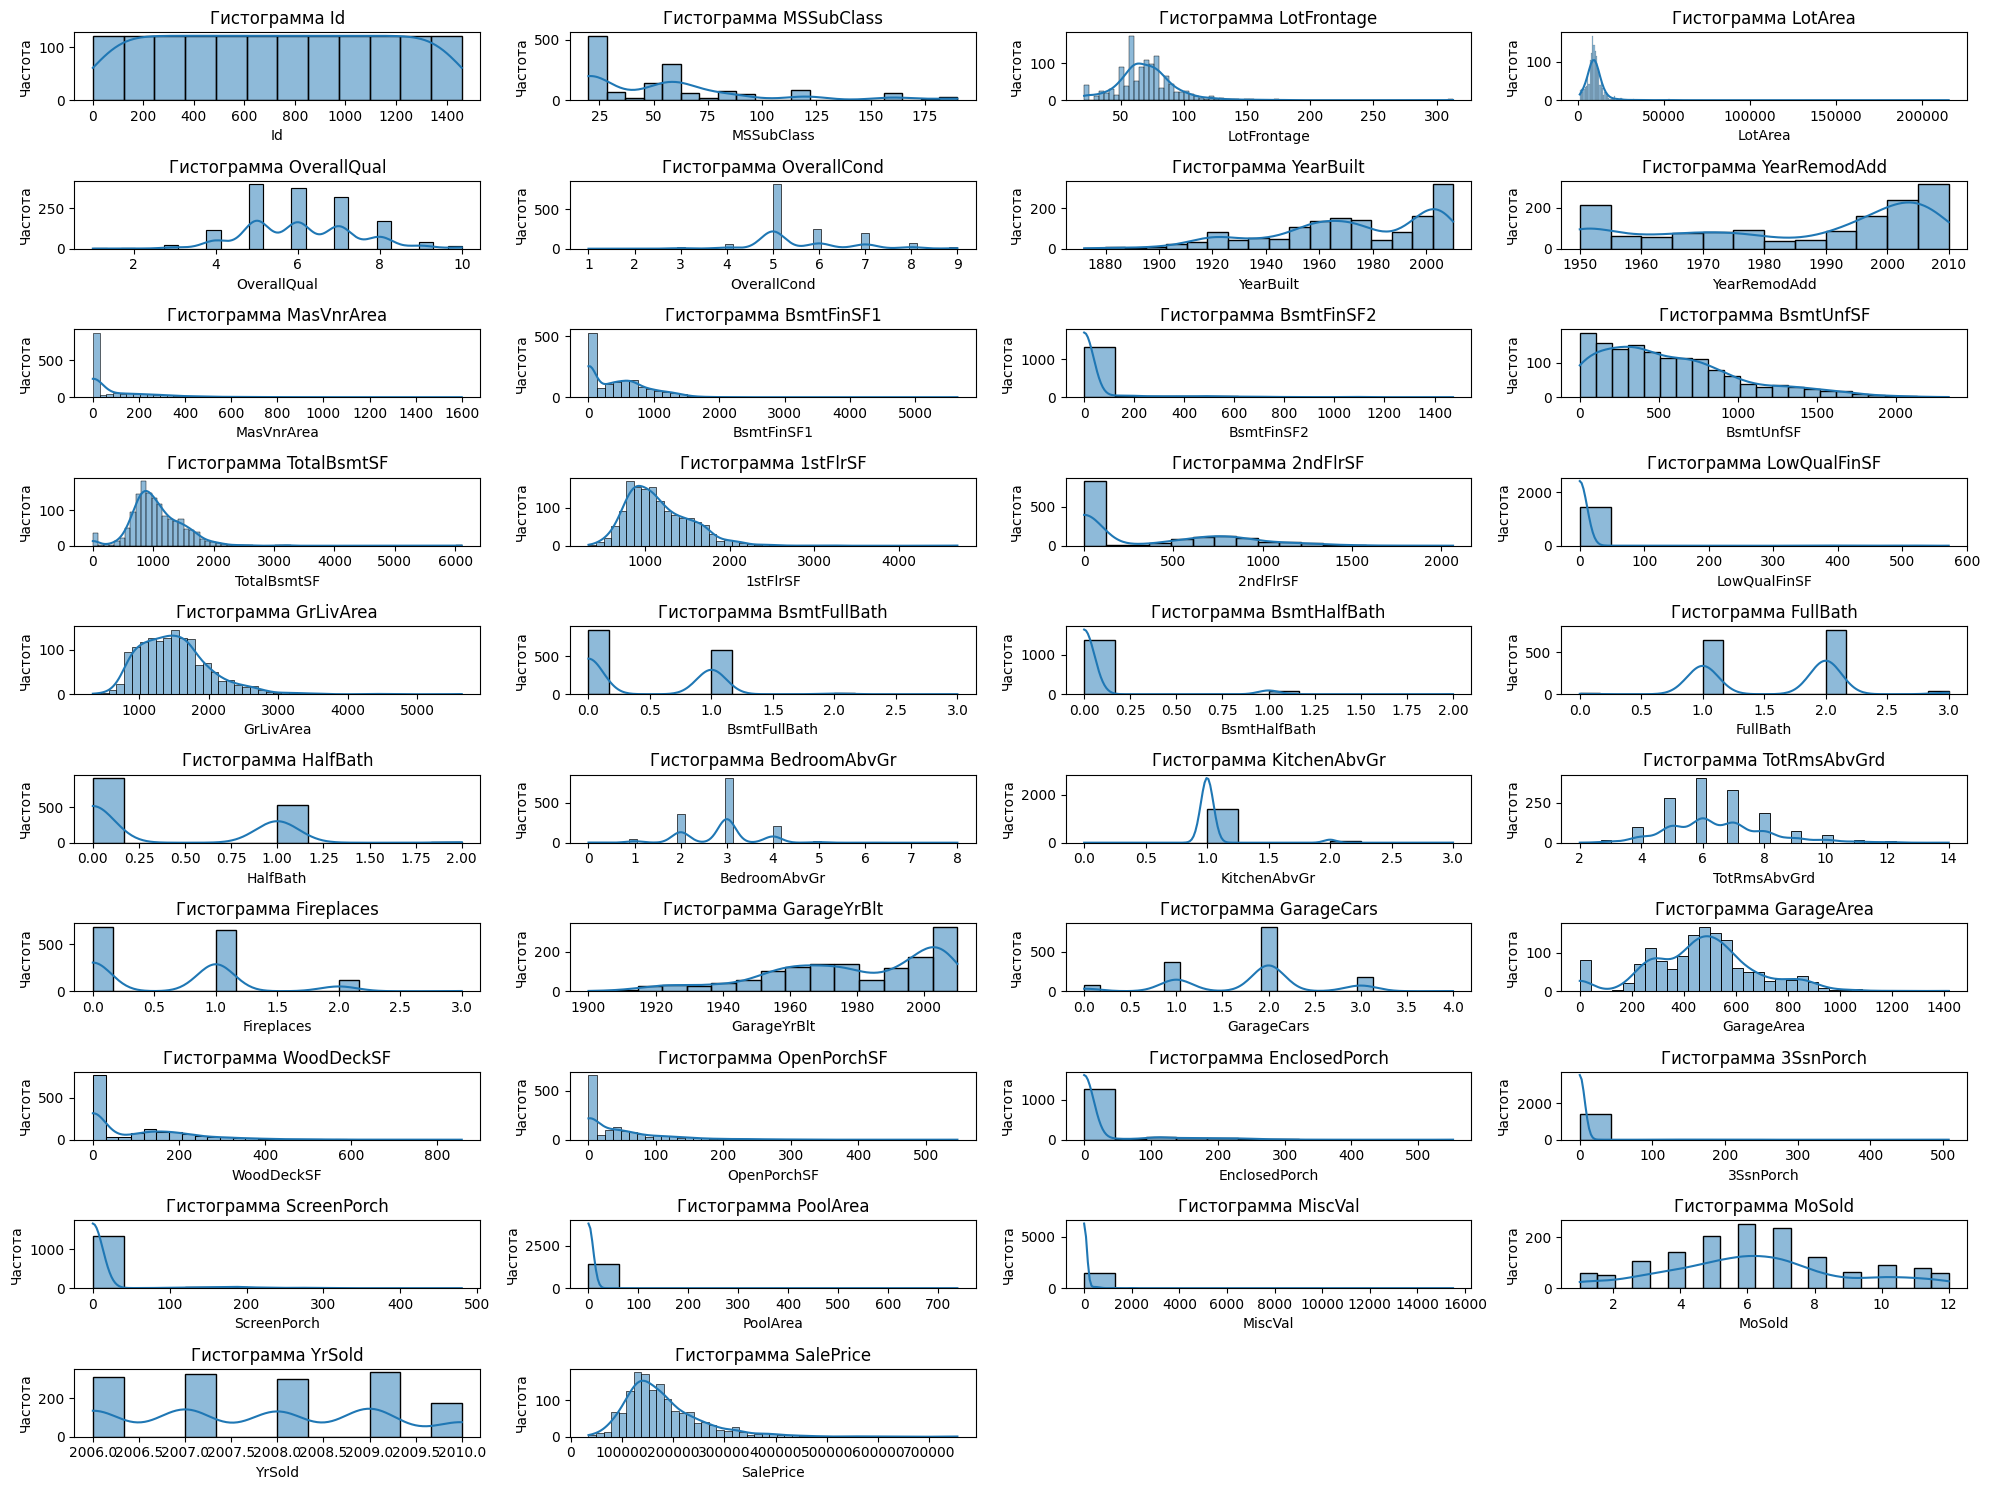

In [5]:
num_cols = train.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(20, 15))
rows = (len(num_cols) // 4) + 1  # Количество строк
for i, col in enumerate(num_cols):
    plt.subplot(rows, 4, i + 1)  # Используем динамическое количество строк
    sns.histplot(train[col], kde=True)  # KDE-кривая для явного распределения
    plt.title(f'Гистограмма {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')

plt.tight_layout()
plt.show()

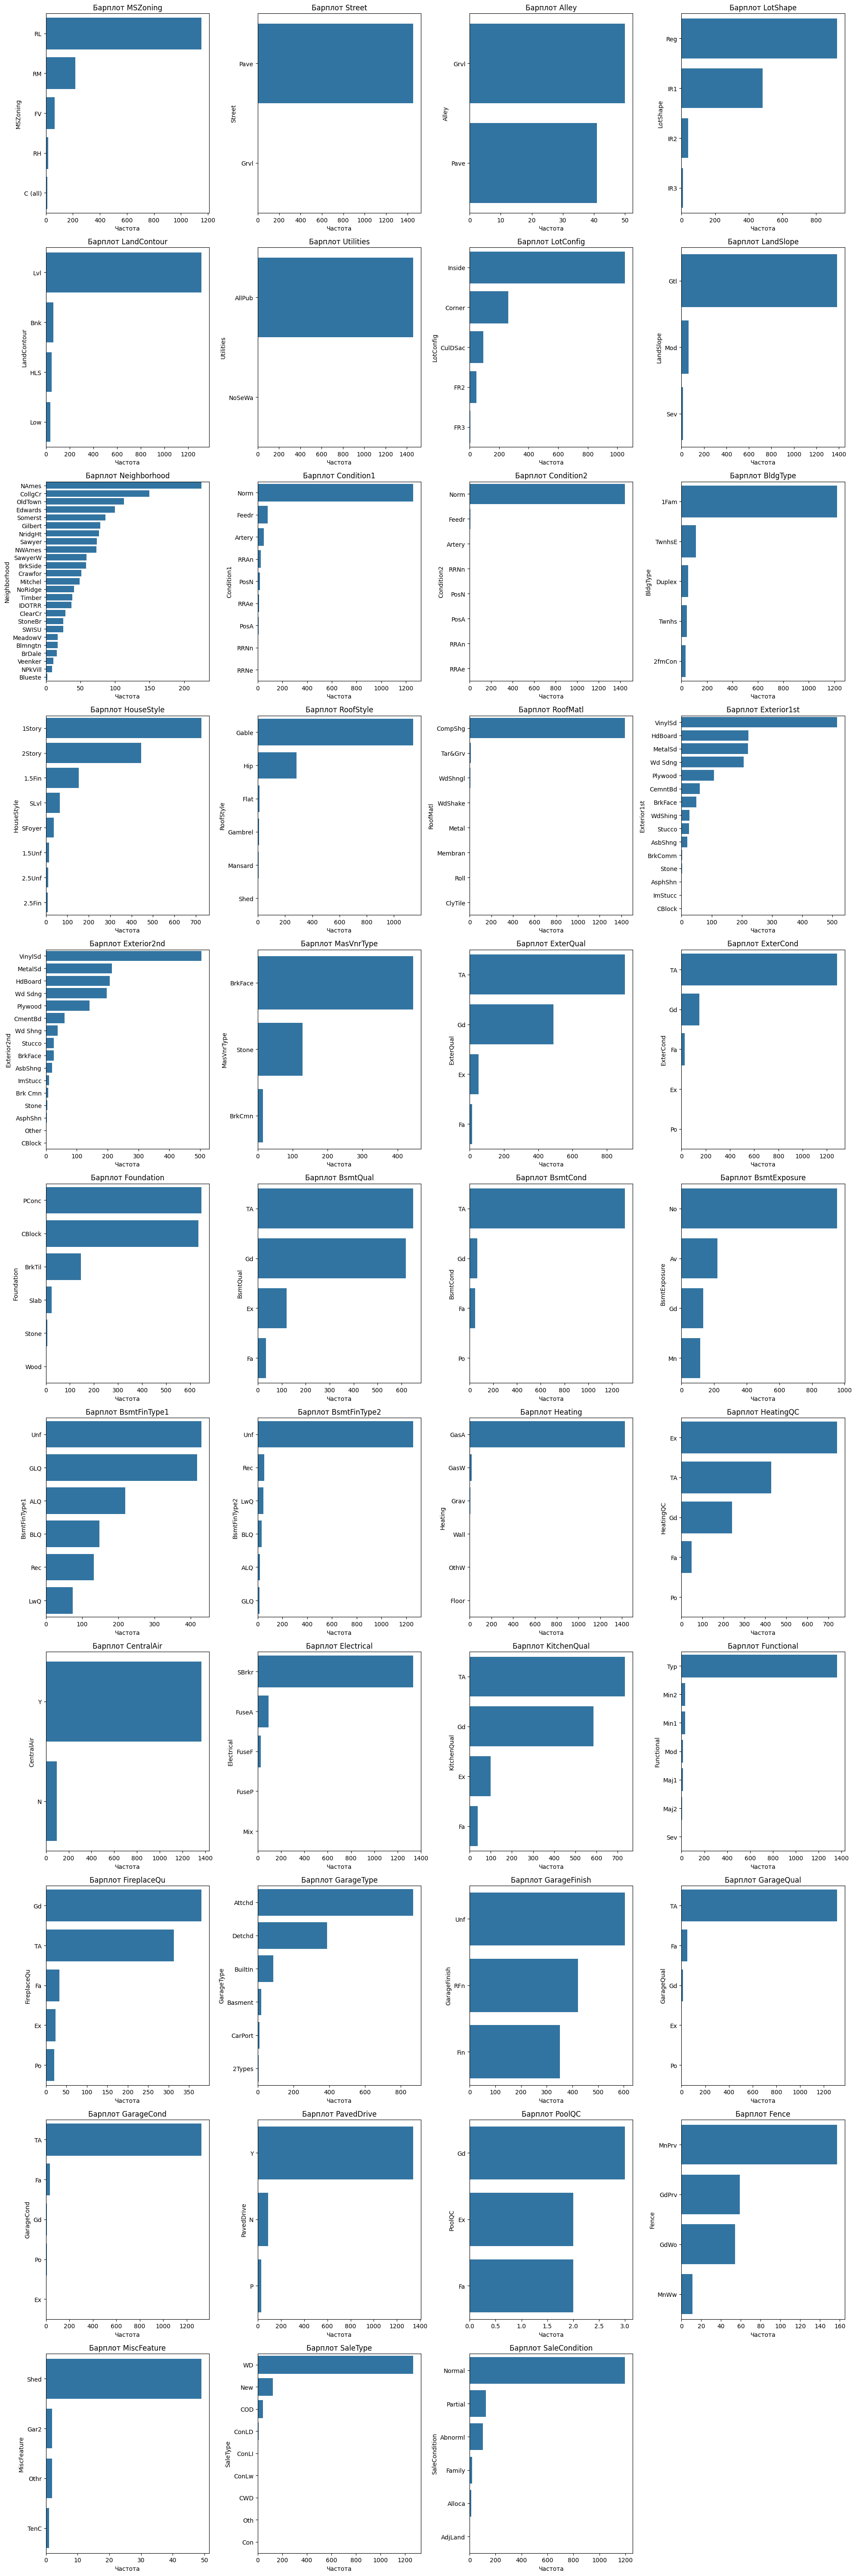

In [6]:
# Субплот с барплотами для категориальных признаков
cat_cols = train.select_dtypes(include=['object']).columns

plt.figure(figsize=(20, 60))
rows = math.ceil(len(cat_cols) / 4)  # Количество строк для 4 колонок
for i, col in enumerate(cat_cols):
    plt.subplot(rows, 4, i + 1)
    sns.countplot(y=train[col], order=train[col].value_counts().index)
    plt.title(f'Барплот {col}')
    plt.xlabel('Частота')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

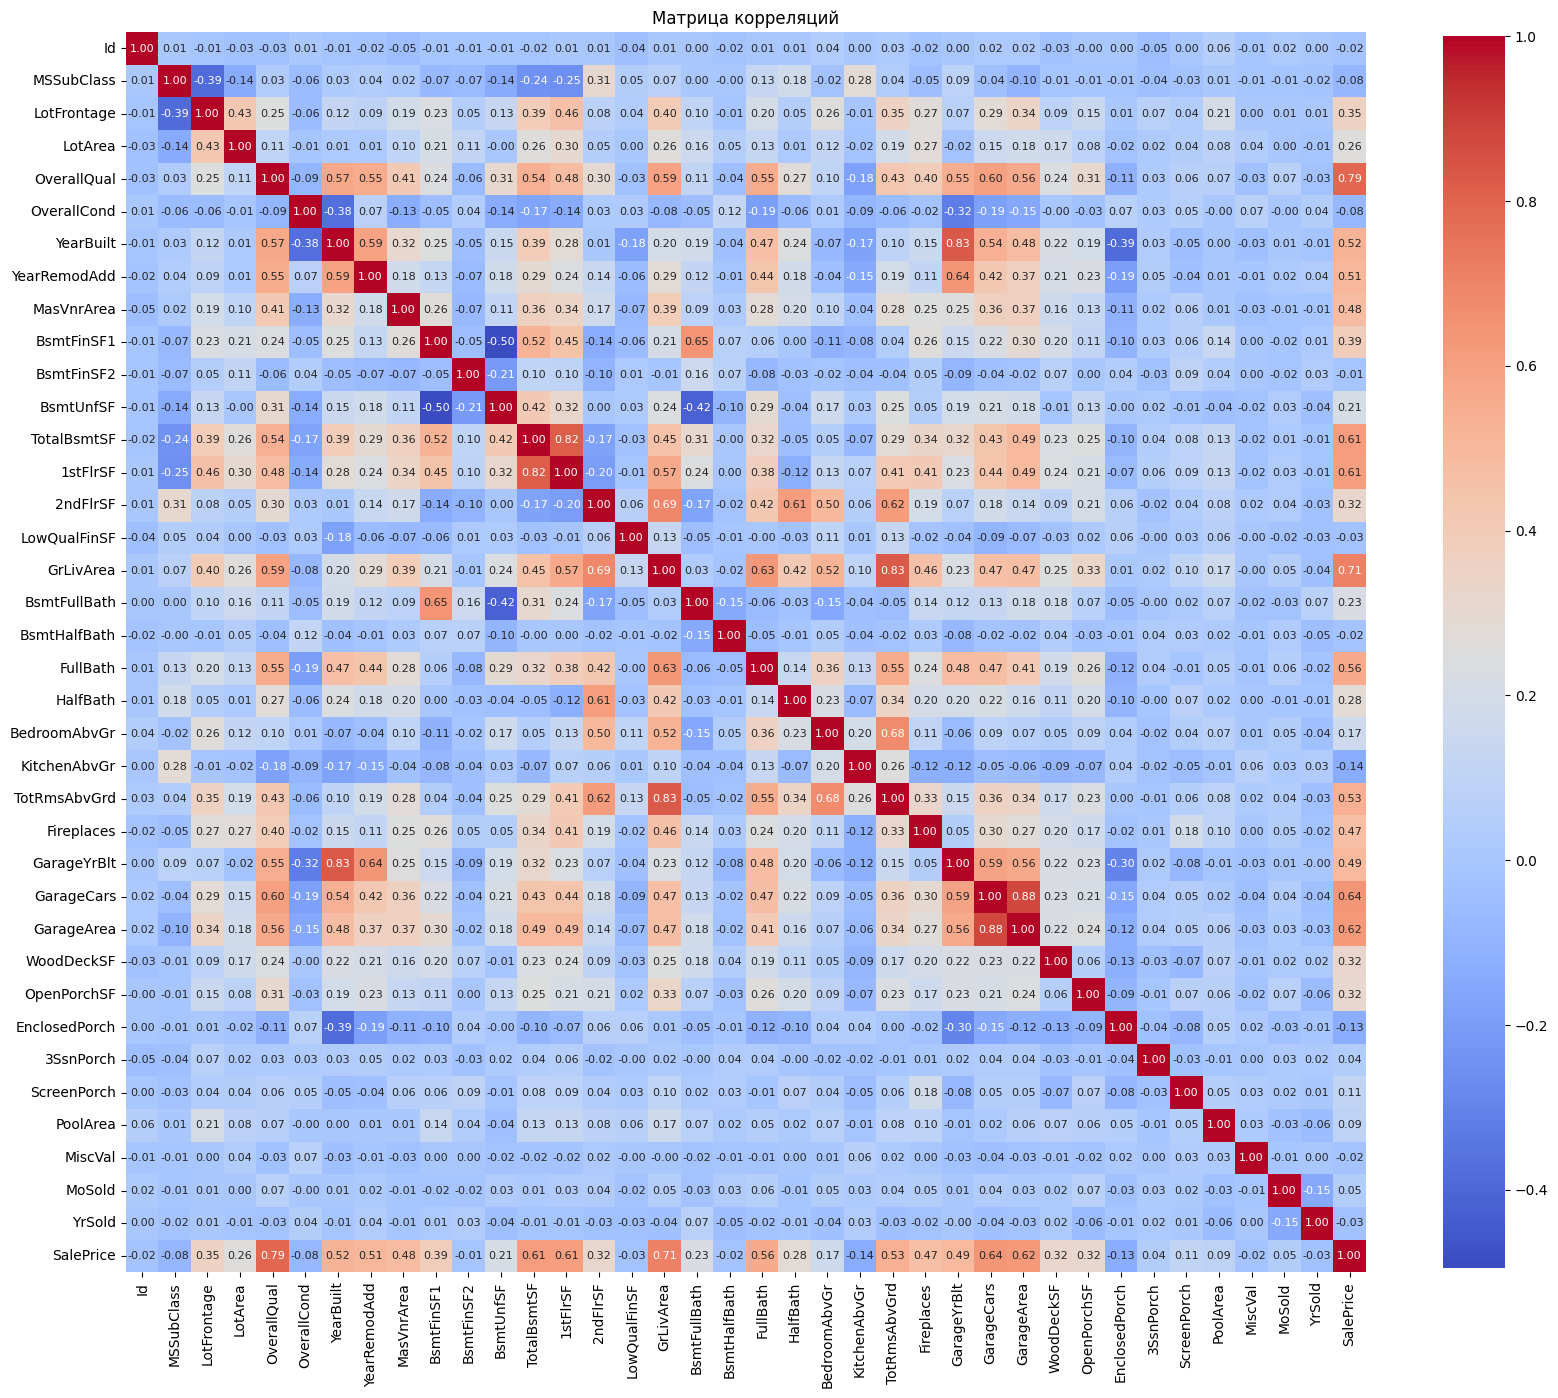

In [7]:
correlation_matrix = train.select_dtypes(include=[np.number]).corr()

# Построение матрицы корреляций
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, annot_kws={"size": 8})  # Уменьшаем размер аннотаций
plt.title('Матрица корреляций')
plt.show()

In [8]:
# def remove_outliers_iqr(train):
#     for col in train.select_dtypes(include=np.number).columns:  # Только числовые колонки
#         Q1 = train[col].quantile(0.05)
#         Q3 = train[col].quantile(0.95)
#         IQR = Q3 - Q1

#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR

#         train[col] = np.where((train[col] < lower_bound) | (train[col] > upper_bound), np.nan, train[col])

#     return train

In [9]:
train['SalePrice'] = np.log(train['SalePrice'])


In [10]:
train['SalePrice']

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1455    12.072541
1456    12.254863
1457    12.493130
1458    11.864462
1459    11.901583
Name: SalePrice, Length: 1460, dtype: float64

In [606]:
train.shape, test.shape

((1460, 81), (1459, 80))

## Удаление выбросов


In [159]:
model = IsolationForest(contamination=0.05)  # Укажите уровень загрязнения
model.fit(train[num_cols])
predictions = model.predict(train[num_cols])
# train['outliers'] = train.fit_predict(train[['value']])
print(predictions)

ValueError: Input X contains NaN.
IsolationForest does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [13]:
combined_df = pd.concat([train, test], ignore_index=True)

In [14]:
combined_df.shape


(2919, 81)

# Препроцессор

## Inputer

In [11]:
pd.reset_option('all')

In [15]:
pd.DataFrame(data={'NaN_count': combined_df.isna().mean(), 'data_type':combined_df.dtypes})

,NaN_count,data_type
Id,0.000000,int64
MSSubClass,0.000000,int64
MSZoning,0.001370,object
LotFrontage,0.166495,float64
LotArea,0.000000,int64
...,...,...
MoSold,0.000000,int64
YrSold,0.000000,int64
SaleType,0.000343,object
SaleCondition,0.000000,object


In [16]:
drop_features = ['Id', '1stFlrSF', '2ndFlrSF', 'MoSold', 'YrSold', 'RoofMatl', 'Utilities']
No_list = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
           'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
mean_list = ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
             'GarageYrBlt', 'GarageCars',  'GarageArea']
obj_list = ['MSZoning', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Electrical', 'KitchenQual', 'Functional',  'SaleType']


my_imputer = ColumnTransformer(
    transformers=[
        ('drop_features', 'drop', drop_features),
        ('nan_imputer', SimpleImputer(strategy='constant', fill_value='NO'), No_list),
        ('num_imputer', SimpleImputer(strategy='mean'), mean_list),
        ('obj_imputer', SimpleImputer(strategy='most_frequent'), obj_list)
        
    ],
    verbose_feature_names_out=False,
    remainder='passthrough'
)  

In [17]:
filled_data = my_imputer.fit_transform(combined_df)
filled_data.head(15)


,Alley,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,FireplaceQu,GarageType,GarageFinish,GarageQual,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SaleCondition,SalePrice
0,NO,Gd,TA,No,GLQ,Unf,NO,Attchd,RFn,TA,...,Y,0,61,0,0,0,0,0,Normal,12.247694
1,NO,Gd,TA,Gd,ALQ,Unf,TA,Attchd,RFn,TA,...,Y,298,0,0,0,0,0,0,Normal,12.109011
2,NO,Gd,TA,Mn,GLQ,Unf,TA,Attchd,RFn,TA,...,Y,0,42,0,0,0,0,0,Normal,12.317167
3,NO,TA,Gd,No,ALQ,Unf,Gd,Detchd,Unf,TA,...,Y,0,35,272,0,0,0,0,Abnorml,11.849398
4,NO,Gd,TA,Av,GLQ,Unf,TA,Attchd,RFn,TA,...,Y,192,84,0,0,0,0,0,Normal,12.429216
5,NO,Gd,TA,No,GLQ,Unf,NO,Attchd,Unf,TA,...,Y,40,30,0,320,0,0,700,Normal,11.870600
6,NO,Ex,TA,Av,GLQ,Unf,Gd,Attchd,RFn,TA,...,Y,255,57,0,0,0,0,0,Normal,12.634603
7,NO,Gd,TA,Mn,ALQ,BLQ,TA,Attchd,RFn,TA,...,Y,235,204,228,0,0,0,350,Normal,12.206073
8,NO,TA,TA,No,Unf,Unf,TA,Detchd,Unf,Fa,...,Y,90,0,205,0,0,0,0,Abnorml,11.774520
9,NO,TA,TA,No,GLQ,Unf,TA,Attchd,RFn,Gd,...,Y,0,4,0,0,0,0,0,Normal,11.678440


In [18]:
pd.DataFrame(data={'NaN_count': filled_data.isna().sum(), 'data_type':filled_data.dtypes})

,NaN_count,data_type
Alley,0,object
BsmtQual,0,object
BsmtCond,0,object
BsmtExposure,0,object
BsmtFinType1,0,object
...,...,...
ScreenPorch,0,int64
PoolArea,0,int64
MiscVal,0,int64
SaleCondition,0,object


## Scaler

In [19]:
norms_cols = filled_data.select_dtypes(include=[np.number]).columns
norms_cols

Index(['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'MSSubClass', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'LowQualFinSF', 'GrLivArea',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice'],
      dtype='object')

In [20]:
norms_cols = norms_cols[:-1]
norms_cols

Index(['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'MSSubClass', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'LowQualFinSF', 'GrLivArea',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [21]:
my_scaler = ColumnTransformer(
    [
        ('norm_scaler', StandardScaler(), norms_cols)
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough'
)



## Encoder

In [22]:
encod_cols = filled_data.select_dtypes(include=['object']).columns
encod_cols

Index(['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
       'MSZoning', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Electrical',
       'KitchenQual', 'Functional', 'SaleType', 'Street', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'ExterQual',
       'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir',
       'PavedDrive', 'SaleCondition'],
      dtype='object')

In [23]:
# OH_cols = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
#        'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
#        'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
#        'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Electrical',
#        'KitchenQual', 'Functional', 'SaleType', 'Street', 'LotShape',
#        'LandContour', 'LotConfig', 'LandSlope','BldgType', 'HouseStyle', 'RoofStyle', 'ExterQual',
#        'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir',
#        'PavedDrive', 'SaleCondition', 'Neighborhood', 'Condition1', 'Condition2', 'MSZoning']

# TE_cols = ['Neighborhood', 'Condition1', 'Condition2', 'MSZoning']


my_encoder = ColumnTransformer(
    [
        ('my_encoding_oh', OneHotEncoder(sparse_output=False), encod_cols),
        # ('my_encoding_te', TargetEncoder(), TE_cols)
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)

## Логарифмирование

In [448]:
combined_df[['BsmtUnfSF', 'GrLivArea', 'TotalBsmtSF', 'LotFrontage', 'GarageArea', 'GarageYrBlt']].head(15)

,BsmtUnfSF,GrLivArea,TotalBsmtSF,LotFrontage,GarageArea,GarageYrBlt
0,150.0000,1710,856.0000,65.0000,548.0000,2003.0000
1,284.0000,1262,1262.0000,80.0000,460.0000,1976.0000
2,434.0000,1786,920.0000,68.0000,608.0000,2001.0000
3,540.0000,1717,756.0000,60.0000,642.0000,1998.0000
4,490.0000,2198,1145.0000,84.0000,836.0000,2000.0000
5,64.0000,1362,796.0000,85.0000,480.0000,1993.0000
6,317.0000,1694,1686.0000,75.0000,636.0000,2004.0000
7,216.0000,2090,1107.0000,NaN,484.0000,1973.0000
8,952.0000,1774,952.0000,51.0000,468.0000,1931.0000
9,140.0000,1077,991.0000,50.0000,205.0000,1939.0000


In [183]:
negative_values = combined_df[combined_df[['BsmtUnfSF', 'GrLivArea', 'TotalBsmtSF', 'LotFrontage', 'GarageArea', 'GarageYrBlt']].lt(0).any(axis=1)]

if not negative_values.empty:
    print("Найдены отрицательные значения в следующих строках:")
    print(negative_values)
else:
    print("Отрицательных значений нет.")

Отрицательных значений нет.


In [184]:
log_columns = ['BsmtUnfSF', 'GrLivArea', 'TotalBsmtSF', 'LotFrontage', 'GarageArea', 'GarageYrBlt']


In [185]:
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        # Проверяем значения и предупреждаем пользователя
        if (X[self.columns] <= 0).any().any():
            print("Внимание: в данных есть нулевые или отрицательные значения.")
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            if X_copy[col].min() <= 0:
                # Можно заменить нулевые и отрицательные значения, например, на 1
                X_copy[col] = np.where(X_copy[col] <= 0, 1, X_copy[col])
            X_copy[col] = np.log1p(X_copy[col])  # Логарифмируем
        return X_copy

## Preprocessor

In [24]:
preprocessor = Pipeline(
    [
        ('imputer', my_imputer),
        ('scaler', my_scaler),
        ('encoder', my_encoder)
        
    ]
)

In [26]:
X = combined_df.drop(columns=['SalePrice'])  # Все, кроме целевого столбца
y = combined_df['SalePrice']  # Целевая переменная

pre_data = preprocessor.fit_transform(X, y)
pd.reset_option('display.max_rows')

In [27]:
pre_data.shape

(2919, 287)

In [30]:
pre_data['SalePrice'] = y

In [31]:
pre_data['SalePrice'] 

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
2914          NaN
2915          NaN
2916          NaN
2917          NaN
2918          NaN
Name: SalePrice, Length: 2919, dtype: float64

In [491]:
def remove_highly_correlated_columns(df, threshold=0.9):
    # Вычисляем корреляционную матрицу
    corr_matrix = df.corr().abs()
    
    # Создаем массив для хранения столбцов для удаления
    to_drop = set()

    # Проход по всем столбцам и их корреляции
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            # Если корреляция выше порога и столбец не был уже помечен для удаления
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]  # имя столбца с высокой корреляцией
                to_drop.add(colname)

    # Удаляем столбцы из DataFrame, кроме последнего
    last_column = df.columns[-1]
    to_drop.discard(last_column)  # Убедимся, что последний столбец не будет удалён

    # Удаляем столбцы из DataFrame
    df.drop(columns=to_drop, inplace=True)
    return df

In [492]:
df_cleaned = remove_highly_correlated_columns(pre_data, threshold=0.8)

In [493]:
df_cleaned.shape

(2919, 255)

In [494]:
df_cleaned['SalePrice']

0      12.2477
1      12.1090
2      12.3172
3      11.8494
4      12.4292
         ...  
2914       NaN
2915       NaN
2916       NaN
2917       NaN
2918       NaN
Name: SalePrice, Length: 2919, dtype: float64

In [460]:
  # columns_to_log = ['BsmtUnfSF', 'GrLivArea', 'TotalBsmtSF', 'LotFrontage', 'GarageArea', 'GarageYrBit']
  # df[columns_to_log] = df[columns_to_log].apply(np.log)

## Разделение выборки


In [32]:
train_2 = pre_data.iloc[: 1460]
test_2 = pre_data.iloc[1460 :]
train_2.shape, test_2.shape

((1460, 288), (1459, 288))

In [194]:
pd.set_option('display.max_rows', None)

In [196]:
model = IsolationForest(contamination=0.05)  # Укажите уровень загрязнения
model.fit(train_2[num_cols_2])
predictions = model.predict(train_2[num_cols_2])
print(predictions)
# train['outliers'] = train.fit_predict(train[['value']])


[array([1, 1, 1, ..., 1, 1, 1])]


In [33]:
X, y = train_2.drop('SalePrice', axis=1), train_2['SalePrice']



## Отбор признаков


In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [418]:
LinReg = LinearRegression()

In [419]:
LinReg.fit(X_train, y_train)

LinearRegression()

In [420]:
print('train root_mean_squared_log_error:', root_mean_squared_log_error(y_train, (LinReg.predict(X_train))))
print('valid root_mean_squared_log_error:', root_mean_squared_log_error(y_valid, (LinReg.predict(X_valid))))

train root_mean_squared_log_error: 0.007139601051725365


ValueError: Root Mean Squared Logarithmic Error cannot be used when targets contain negative values.

In [346]:
test_2 = test_2[final_col]
test_2.shape

(1459, 10)

In [315]:
answer = pd.DataFrame()
answer['Id'] = test['Id']
answer["SalePrice"] = np.exp(LinReg.predict(test_2))
answer.to_csv('submission.csv', index=False)

## DecisionTreeRegressor


In [386]:
DecTree = DecisionTreeRegressor()

In [387]:
DecTree.fit(X_train, y_train)


DecisionTreeRegressor()

In [388]:
print('train root_mean_squared_log_error:', root_mean_squared_log_error(y_train, (DecTree.predict(X_train))))
print('valid root_mean_squared_log_error:', root_mean_squared_log_error(y_valid, (DecTree.predict(X_valid))))

train root_mean_squared_log_error: 0.0
valid root_mean_squared_log_error: 0.014485831897870304


In [389]:
print('train root_mean_squared_log_error:', root_mean_squared_log_error(np.exp(y_train), np.exp(DecTree.predict(X_train))))
print('valid root_mean_squared_log_error:', root_mean_squared_log_error(np.exp(y_valid), np.exp(DecTree.predict(X_valid))))

train root_mean_squared_log_error: 0.0
valid root_mean_squared_log_error: 0.18682941535290418


In [35]:
cb = CatBoostRegressor(eval_metric='RMSE')

cb.fit(
    X_train,
    y_train,
    eval_set=(X_valid, y_valid),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.052178
0:	learn: 0.3775922	test: 0.4195288	best: 0.4195288 (0)	total: 49.3ms	remaining: 49.2s
1:	learn: 0.3647166	test: 0.4057272	best: 0.4057272 (1)	total: 50.9ms	remaining: 25.4s
2:	learn: 0.3530792	test: 0.3941237	best: 0.3941237 (2)	total: 52ms	remaining: 17.3s
3:	learn: 0.3421305	test: 0.3819838	best: 0.3819838 (3)	total: 53.4ms	remaining: 13.3s
4:	learn: 0.3317986	test: 0.3711974	best: 0.3711974 (4)	total: 54.5ms	remaining: 10.8s
5:	learn: 0.3211372	test: 0.3605737	best: 0.3605737 (5)	total: 55.5ms	remaining: 9.19s
6:	learn: 0.3110993	test: 0.3498244	best: 0.3498244 (6)	total: 56.4ms	remaining: 8s
7:	learn: 0.3024207	test: 0.3412664	best: 0.3412664 (7)	total: 57.6ms	remaining: 7.14s
8:	learn: 0.2943272	test: 0.3326414	best: 0.3326414 (8)	total: 58.6ms	remaining: 6.45s
9:	learn: 0.2859552	test: 0.3246006	best: 0.3246006 (9)	total: 59.8ms	remaining: 5.92s
10:	learn: 0.2782192	test: 0.3162927	best: 0.3162927 (10)	total: 60.7ms	remaining: 5.46s
11:	learn: 0.270

In [36]:
print('train root_mean_squared_error:', root_mean_squared_error(y_train, (cb.predict(X_train))))
print('valid root_mean_squared_error:', root_mean_squared_error(y_valid, (cb.predict(X_valid))))

train root_mean_squared_error: 0.041539381727701837
valid root_mean_squared_error: 0.12908642700775214


In [619]:
cb.save_model('model.cbm')

In [594]:
preprocessor = Pipeline(
    [
        ('imputer', my_imputer),
        ('scaler', my_scaler),
        ('encoder', my_encoder)
        
    ]
)

In [37]:
ml_pipline = Pipeline(
    [
        ('imputer', my_imputer),
        ('scaler', my_scaler),
        ('encoder', my_encoder),
        ('model', cb)
        
    ]
)

In [38]:
joblib.dump(ml_pipline, 'ml_pipline.pkl')

['ml_pipline.pkl']

In [502]:
answer = pd.DataFrame()
answer['Id'] = test['Id']
answer["SalePrice"] = np.exp(cb.predict(test_2))
answer.head()
answer.to_csv('submission.csv', index=False)

In [392]:
def objective(trial):
    # Параметры модели
    model_params = {
        'depth': trial.suggest_int('max_depth', 1, 10, step=1),
        'iterations': trial.suggest_int('n_estimators', 20, 100, step=5),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),  # Регуляризация L2
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),  # Бутстреп
        'random_strength': trial.suggest_float('random_strength', 0, 10),  # Случайность
        'max_bin': trial.suggest_int('max_bin', 5, 255, step=5),  # Макс бинтов
        'verbose': 0,  # Отключить вывод
        'eval_metric': 'RMSE'  # Метрика для оценки
    }

    # Устанавливаем параметры CatBoostRegressor
    model = CatBoostRegressor(**model_params)

    cv = KFold(n_splits=5, random_state=42, shuffle=True)

    # Выполняем кросс-валидацию по RMSE
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')

    # Инвертируем знаки, так как мы используем отрицательное RMSE для оценки
    rmse = -scores.mean()
    
    return rmse  # Возвращаем RMSE для минимизации

In [393]:
# Создание и запуск оптимизации
study = optuna.create_study(direction='minimize')  
study.optimize(objective, n_trials=100)

# Вывод результатов
best_param_cat = study.best_params
best_value_cat = study.best_value

print(f"Лучшие параметры: {best_param_cat}")
print(f"Лучшее значение RMSE: {best_value_cat}")

[I 2024-09-27 13:24:50,675] A new study created in memory with name: no-name-464bb1d3-41eb-4296-bc85-cfa3fb820567
[I 2024-09-27 13:24:51,065] Trial 0 finished with value: 0.36991173347505096 and parameters: {'max_depth': 8, 'n_estimators': 30, 'learning_rate': 0.004686740015891981, 'l2_leaf_reg': 6.835714813816981, 'bagging_temperature': 0.6650388033458476, 'random_strength': 2.2319300192937908, 'max_bin': 255}. Best is trial 0 with value: 0.36991173347505096.
[I 2024-09-27 13:24:51,253] Trial 1 finished with value: 0.3972008224077858 and parameters: {'max_depth': 6, 'n_estimators': 25, 'learning_rate': 0.0003374994439997707, 'l2_leaf_reg': 3.7058369820389094, 'bagging_temperature': 0.25629516341104797, 'random_strength': 9.536934053665728, 'max_bin': 160}. Best is trial 0 with value: 0.36991173347505096.
[I 2024-09-27 13:24:54,310] Trial 2 finished with value: 0.39673504581358515 and parameters: {'max_depth': 10, 'n_estimators': 70, 'learning_rate': 0.00014017541496992353, 'l2_leaf_re

Лучшие параметры: {'max_depth': 5, 'n_estimators': 75, 'learning_rate': 0.09832032051663658, 'l2_leaf_reg': 4.928810108485369, 'bagging_temperature': 0.44195501072341226, 'random_strength': 0.6710358691747285, 'max_bin': 120}
Лучшее значение RMSE: 0.1321196541671288


In [394]:
cat_best = CatBoostRegressor(**best_param_cat)

In [395]:
cat_best.fit(
    X_train,
    y_train,
    eval_set=(X_valid, y_valid),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3654926	test: 0.4064029	best: 0.4064029 (0)	total: 1.43ms	remaining: 106ms
1:	learn: 0.3430384	test: 0.3827360	best: 0.3827360 (1)	total: 3.22ms	remaining: 118ms
2:	learn: 0.3240335	test: 0.3630648	best: 0.3630648 (2)	total: 4.65ms	remaining: 112ms
3:	learn: 0.3069221	test: 0.3452866	best: 0.3452866 (3)	total: 6.13ms	remaining: 109ms
4:	learn: 0.2894669	test: 0.3264153	best: 0.3264153 (4)	total: 7.32ms	remaining: 102ms
5:	learn: 0.2745848	test: 0.3109775	best: 0.3109775 (5)	total: 8.37ms	remaining: 96.3ms
6:	learn: 0.2616015	test: 0.2974547	best: 0.2974547 (6)	total: 9.69ms	remaining: 94.1ms
7:	learn: 0.2489105	test: 0.2846536	best: 0.2846536 (7)	total: 10.8ms	remaining: 90.8ms
8:	learn: 0.2385378	test: 0.2734965	best: 0.2734965 (8)	total: 12.1ms	remaining: 88.4ms
9:	learn: 0.2275725	test: 0.2630731	best: 0.2630731 (9)	total: 13.2ms	remaining: 86.1ms
10:	learn: 0.2177352	test: 0.2523492	best: 0.2523492 (10)	total: 14.3ms	remaining: 83ms
11:	learn: 0.2099370	test: 0.2431274	

In [300]:
print('train root_mean_squared_log_error:', root_mean_squared_log_error(np.exp(y_train), np.exp(cat_best.predict(X_train))))
print('valid root_mean_squared_log_error:', root_mean_squared_log_error(np.exp(y_valid), np.exp(cat_best.predict(X_valid))))

train root_mean_squared_log_error: 0.11536635829944686
valid root_mean_squared_log_error: 0.14626917524847308


In [301]:
lgb = LGBMRegressor(verbose=0)

# Обучение модели с использованием параметра early_stopping_rounds
lgb.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='rmse'  # Добавляем оценочную метрику
      # Вывод сообщений о прогрессе обучения
)

LGBMRegressor(verbose=0)

In [302]:
print('train root_mean_squared_log_error:', root_mean_squared_log_error(np.exp(y_train), np.exp(lgb.predict(X_train))))
print('valid root_mean_squared_log_error:', root_mean_squared_log_error(np.exp(y_valid), np.exp(lgb.predict(X_valid))))

train root_mean_squared_log_error: 0.06701160735206334
valid root_mean_squared_log_error: 0.15591376241358015


In [303]:
def objective(trial):
    # Параметры модели
    model_params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10, step=1),
        'n_estimators': trial.suggest_int('n_estimators', 20, 100, step=5),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150, step=5),  # Число листьев
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),  # Минимальное количество данных на лист
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),  # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),  # L2 regularization
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1),  # Доля данных для бутстрапинга
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1),  # Доля признаков
        'verbose': -1,  # Отключить вывод
    }

    # Устанавливаем параметры LGBMRegressor
    model = LGBMRegressor(**model_params)

    cv = KFold(n_splits=5, random_state=42, shuffle=True)

    # Выполняем кросс-валидацию по RMSE
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')

    # Инвертируем знаки, так как мы используем отрицательное RMSE для оценки
    rmse = -scores.mean()
    
    return rmse  # Возвращаем RMSE для минимизации

In [304]:
study = optuna.create_study(direction='minimize')  
study.optimize(objective, n_trials=100)

# Вывод результатов
best_param_lgb = study.best_params
best_value_lgb = study.best_value

print(f"Лучшие параметры: {best_param_lgb}")
print(f"Лучшее значение RMSE: {best_value_lgb}")

[I 2024-09-27 12:41:28,774] A new study created in memory with name: no-name-7ba6d306-ebb0-4842-b544-fd03f9af15cd
[I 2024-09-27 12:41:29,026] Trial 0 finished with value: 0.38694176729733787 and parameters: {'max_depth': 4, 'n_estimators': 65, 'learning_rate': 0.0007126242909432287, 'num_leaves': 25, 'min_data_in_leaf': 25, 'reg_alpha': 3.5706814848416886, 'reg_lambda': 3.8370033209868506, 'bagging_fraction': 0.8396612263132024, 'feature_fraction': 0.9867871303201844}. Best is trial 0 with value: 0.38694176729733787.
[I 2024-09-27 12:41:29,213] Trial 1 finished with value: 0.32286751817160214 and parameters: {'max_depth': 7, 'n_estimators': 20, 'learning_rate': 0.015869233272703277, 'num_leaves': 125, 'min_data_in_leaf': 25, 'reg_alpha': 0.5168262154445802, 'reg_lambda': 3.70741645650583, 'bagging_fraction': 0.7059914080556058, 'feature_fraction': 0.9000477862257079}. Best is trial 1 with value: 0.32286751817160214.
[I 2024-09-27 12:41:29,465] Trial 2 finished with value: 0.34665632858

Лучшие параметры: {'max_depth': 3, 'n_estimators': 95, 'learning_rate': 0.09878967455332531, 'num_leaves': 90, 'min_data_in_leaf': 4, 'reg_alpha': 1.1272340443213908, 'reg_lambda': 0.8201275908971989, 'bagging_fraction': 0.7621817019534992, 'feature_fraction': 0.9177699174354472}
Лучшее значение RMSE: 0.14749648679632177


In [114]:
lgb_best = LGBMRegressor(**best_param_lgb)

In [115]:
lgb_best.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='rmse'  # Добавляем оценочную метрику
      # Вывод сообщений о прогрессе обучения
)

LGBMRegressor(bagging_fraction=0.9464727748683478,
              feature_fraction=0.5584700240705187,
              learning_rate=0.07953477730516413, max_depth=5,
              min_data_in_leaf=1, num_leaves=60, reg_alpha=0.025496316374610195,
              reg_lambda=1.298066535366977)

In [116]:
print('train root_mean_squared_log_error:', root_mean_squared_log_error(np.exp(y_train), np.exp(lgb_best.predict(X_train))))
print('valid root_mean_squared_log_error:', root_mean_squared_log_error(np.exp(y_valid), np.exp(lgb_best.predict(X_valid))))

train root_mean_squared_log_error: 0.05234596347799684
valid root_mean_squared_log_error: 0.1370983577670743


In [118]:
xgb = XGBRegressor(eval_metric='rmse', verbose=1)  # поменял с 'RMSE' на 'rmse'

# Обучаем модель
xgb.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],  # Оценочный набор  # Останавливаем обучение, если валидационная метрика не улучшается
    verbose=True  # Выводим сообщения о прогрессе обучения
)

[0]	validation_0-rmse:0.33740
[1]	validation_0-rmse:0.27507
[2]	validation_0-rmse:0.23355
[3]	validation_0-rmse:0.20514
[4]	validation_0-rmse:0.18723
[5]	validation_0-rmse:0.17679
[6]	validation_0-rmse:0.16991
[7]	validation_0-rmse:0.16456
[8]	validation_0-rmse:0.15943
[9]	validation_0-rmse:0.15627
[10]	validation_0-rmse:0.15463
[11]	validation_0-rmse:0.15305
[12]	validation_0-rmse:0.15156
[13]	validation_0-rmse:0.15152
[14]	validation_0-rmse:0.15073
[15]	validation_0-rmse:0.14974
[16]	validation_0-rmse:0.14929
[17]	validation_0-rmse:0.14838
[18]	validation_0-rmse:0.14789
[19]	validation_0-rmse:0.14774
[20]	validation_0-rmse:0.14749
[21]	validation_0-rmse:0.14769
[22]	validation_0-rmse:0.14702
[23]	validation_0-rmse:0.14684
[24]	validation_0-rmse:0.14694
[25]	validation_0-rmse:0.14715
[26]	validation_0-rmse:0.14758
[27]	validation_0-rmse:0.14761
[28]	validation_0-rmse:0.14733


/home/aleksey/miniforge3/envs/hos/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:09:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[29]	validation_0-rmse:0.14738
[30]	validation_0-rmse:0.14749
[31]	validation_0-rmse:0.14759
[32]	validation_0-rmse:0.14763
[33]	validation_0-rmse:0.14758
[34]	validation_0-rmse:0.14785
[35]	validation_0-rmse:0.14780
[36]	validation_0-rmse:0.14766
[37]	validation_0-rmse:0.14774
[38]	validation_0-rmse:0.14773
[39]	validation_0-rmse:0.14771
[40]	validation_0-rmse:0.14779
[41]	validation_0-rmse:0.14775
[42]	validation_0-rmse:0.14775
[43]	validation_0-rmse:0.14771
[44]	validation_0-rmse:0.14777
[45]	validation_0-rmse:0.14767
[46]	validation_0-rmse:0.14757
[47]	validation_0-rmse:0.14779
[48]	validation_0-rmse:0.14720
[49]	validation_0-rmse:0.14713
[50]	validation_0-rmse:0.14715
[51]	validation_0-rmse:0.14722
[52]	validation_0-rmse:0.14726
[53]	validation_0-rmse:0.14729
[54]	validation_0-rmse:0.14729
[55]	validation_0-rmse:0.14747
[56]	validation_0-rmse:0.14775
[57]	validation_0-rmse:0.14777
[58]	validation_0-rmse:0.14763
[59]	validation_0-rmse:0.14764
[60]	validation_0-rmse:0.14744
[61]	val

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [119]:
print('train root_mean_squared_error:', root_mean_squared_error(y_train, (xgb.predict(X_train))))
print('valid root_mean_squared_error:', root_mean_squared_error(y_valid, (xgb.predict(X_valid))))

train root_mean_squared_error: 0.007736507074622024
valid root_mean_squared_error: 0.14729911856494213


In [100]:
def objective(trial):
    # Параметры модели
    model_params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10, step=1),  # Максимальная глубина дерева
        'n_estimators': trial.suggest_int('n_estimators', 20, 100, step=5),  # Количество деревьев
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),  # Темп обучения
        'gamma': trial.suggest_float('gamma', 0, 5),  # Минимальное уменьшение потерь для дальнейшего разделения узлов
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # Минимальная сумма весов для дочерних узлов
        'subsample': trial.suggest_float('subsample', 0.5, 1),  # Доля выборки для обучения каждого дерева
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),  # Доля признаков для выбора в каждом дереве
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),  # L1 регуляризация
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),  # L2 регуляризация
        'verbosity': 0  # Отключить вывод
    }

    # Устанавливаем параметры XGBRegressor
    model = XGBRegressor(**model_params)

    cv = KFold(n_splits=5, random_state=42, shuffle=True)

    # Выполняем кросс-валидацию по RMSE
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')

    # Инвертируем знаки, так как мы используем отрицательное RMSE для оценки
    rmse = -scores.mean()
    
    return rmse  # Возвращаем RMSE для минимизации


In [101]:
study = optuna.create_study(direction='minimize')  
study.optimize(objective, n_trials=100)

# Вывод результатов
best_param_xgb = study.best_params
best_value_xgb = study.best_value

print(f"Лучшие параметры: {best_param_xgb}")
print(f"Лучшее значение RMSE: {best_value_xgb}")

[I 2024-09-26 20:59:37,857] A new study created in memory with name: no-name-c5e56568-a19e-43e0-8c55-f738dc4a5eeb
[I 2024-09-26 20:59:38,591] Trial 0 finished with value: 0.3979802111919034 and parameters: {'max_depth': 1, 'n_estimators': 55, 'learning_rate': 8.524339185762808e-05, 'gamma': 3.810547813050747, 'min_child_weight': 8, 'subsample': 0.6208110777944451, 'colsample_bytree': 0.8244811010491845, 'reg_alpha': 1.5570069204525887, 'reg_lambda': 3.004389570995438}. Best is trial 0 with value: 0.3979802111919034.
[I 2024-09-26 20:59:39,297] Trial 1 finished with value: 0.22390831546253764 and parameters: {'max_depth': 7, 'n_estimators': 20, 'learning_rate': 0.06581066571570016, 'gamma': 0.9616743378552423, 'min_child_weight': 4, 'subsample': 0.637973944104265, 'colsample_bytree': 0.9486837493316838, 'reg_alpha': 2.31665293360518, 'reg_lambda': 1.6918197133001966}. Best is trial 1 with value: 0.22390831546253764.
[I 2024-09-26 20:59:40,703] Trial 2 finished with value: 0.247755302854

Лучшие параметры: {'max_depth': 10, 'n_estimators': 100, 'learning_rate': 0.099039304963726, 'gamma': 0.0013444449630375423, 'min_child_weight': 4, 'subsample': 0.8887667533459571, 'colsample_bytree': 0.7946047523717028, 'reg_alpha': 4.128382598464558, 'reg_lambda': 3.10830898027054}
Лучшее значение RMSE: 0.14635846949655734


In [ ]:
xgb_best = XGBRegressor(eval_metric='rmse', verbose=1)  

# Обучаем модель
xgb.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],  # Оценочный набор
    early_stopping_rounds=10,  # Останавливаем обучение, если валидационная метрика не улучшается
    verbose=True  # Выводим сообщения о прогрессе обучения
)

In [ ]:
print('train root_mean_squared_log_error:', root_mean_squared_log_error(np.exp(y_train), np.exp(xgb_best.predict(X_train))))
print('valid root_mean_squared_log_error:', root_mean_squared_log_error(np.exp(y_valid), np.exp(xgb_best.predict(X_valid))))

In [160]:
y_pred_test = DecTree.predict(test_2.iloc[:, :-1])

In [162]:
y_pred_test 

array([11.7745202 , 11.96400108, 12.02574909, ..., 11.87059991,
       11.74403719, 12.50539916])

In [163]:
np.exp(y_pred_test )

array([129900., 157000., 167000., ..., 143000., 126000., 269790.])

In [183]:
answer['Id'] = test['Id'] 

In [182]:


answer = pd.DataFrame()

In [184]:
answer['SalePrice'] = np.exp(y_pred_test )
answer


,Id,SalePrice
0,1461,129900.0
1,1462,157000.0
2,1463,167000.0
3,1464,178000.0
4,1465,213500.0
...,...,...
1454,2915,81000.0
1455,2916,80000.0
1456,2917,143000.0
1457,2918,126000.0


In [185]:
answer.to_csv('submission.csv', index=False)
